# 广义径向基函数（RBF）网络 

https://github.com/oarriaga/RBF-Network/tree/master

## RBF网络学习算法

In [1]:
import os
import numpy as np
from nnc import dataset as Data
from nnc.plot_tool import *

In [2]:
# 均方误差函数
def mse(y,y_pred):
    return np.mean((y-y_pred)**2)

#计算径向基距离函数矩阵
def gauss(z,sigma):
    # Gaussian基函数    phi(X,c) = exp{- z/(2simga^2)}
    return np.exp(- z**2/(2*sigma**2))  #按行向量处理

<font size=4 color=blue> **Random-RBF网络**  </font> 

-  <font size=4 face="宋体">随机选择RBF中心的RBF网络学习算法</font>  

In [3]:
# RBF 网络
class random_RBFNet(object):
    
    def __init__(self,input_size,hidden_size,output_size,**kwargs):
        # 初始化RBFNN
        super(random_RBFNet,self).__init__()
        self.input_size = input_size      # 输入维度
        self.hidden_size = hidden_size    # 隐层维度
        self.output_size = output_size    # 输出维度
        
        # RBF网络的基函数
        self.bfunc = kwargs.get('basis',gauss)
        # RBF网络的参数:  weight 权值   基函数中心/扩展常数
        self.param = {}        # 网络参数
        self.param['lambda'] = kwargs.get('Lambda',0.0)   #  正则化系数(Lambda默认为0，即为RBFnet; Lambda>0，即为RRBFnet)
        self.init_param()
    
    def init_param(self,init_W=None): 
        #初始化参数
        self.param['sigma'] = None   #  np.ones(self.hidden_size)     # 各个基函数（Gauss基函数）的扩展常数设为相同 = 1
        self.param['center'] = None   #  np.zeros(((self.hidden_size, self.input_size)))    # 基函数中心
        # center = np.random.random((self.hidden_size, self.input_size))   #(h,1) 基函数中心（50，1）
        if init_W is not None:
            self.param['weight'] = np.array(init_W).reshape(self.hidden_size,self.output_size)
        else:
            self.param['weight'] = np.random.randn(self.hidden_size+1,self.output_size)  # 输出层权值 (包含阈值)
        #self.param['t'] = np.zeros((1,output_size))
    
    def select_centers(self, X):
        # 随机选取RBF中心
        random_args = np.random.choice(X.shape[0], self.hidden_size)
        centers = X[random_args]
        return centers
    
    def cal_sigma(self,C):
        # 根据基函数的中心计算扩展常数  sigma= dmax/sqrt{2M}
        # M = C.shape[1]    # 基函数数目
        dist = []    # 计算各中心之间的最大距离
        for i,ci in enumerate(C):
            for j,cj in enumerate(C):
                if i <= j:
                    dist.append(np.linalg.norm((ci-cj)))
        return np.max(dist)/np.sqrt(2*C.shape[1])
    
    #计算数据与径向基函数中心的距离矩阵（插值矩阵）
    def interpolation_matrix(self,X,C,sigma):
        if not isinstance(sigma,np.ndarray):
            sigma = np.array(sigma)
        print(X.shape,C.shape)
        K = np.zeros((X.shape[0],C.shape[0]))
        for j,cj in enumerate(C):
            K[:,j] = np.linalg.norm((X-cj),axis=1)
        # 使用Gaussian基函数
        self.Phi = self.bfunc(K,sigma)
        return self.Phi  
    
    #输出层输入数据 (加入阈值分量)
    def addIntercept(self,X):   # X.shape = (P,M) 
        return np.hstack((X, np.ones((X.shape[0], 1))))#输出（P,M+1)
    
    def update_weight(self,K,y):
        # 计算权值向量
        if K.shape[0] == K.shape[1]:
            if self.param['lambda'] == 0:
                return np.linalg.pinv(K) @ y
            else:
                G = K + self.param['lambda']*np.eye(K.shape[1])
                return np.linalg.inv(G) @ y
        else:
            if self.param['lambda'] == 0:
                return np.linalg.pinv(K) @ y
            else:
                G = K.T @ K + self.param['lambda']*np.eye(K.shape[1])
                #return np.dot(np.linalg.pinv(G),K.T) @ y
                return np.linalg.pinv(G) @ (K.T @ y)
    

<font size=4 color=blue> **Kmeans-RBF网络**  </font> 

-  <font size=4 face="宋体">自组织聚类选取RBF中心的RBF网络学习算法</font>  

   <font size=4 face="宋体">**第一阶段:** 自组织学习阶段 （采用K-means聚类算法对数据中心进行自组织选择）</font>  
   <font size=4 face="宋体">**第二阶段:** 监督学习阶段 （采用最小二乘法或梯度下降法计算隐层到输出层的权值）</font>  

 <font size=4 color=red> **注：**  </font> <font size=4 face="宋体"> K-means算法 </font> 
 - <font size=4 face="宋体"> 编写 K-means 算法    </font>
 - <font size=4 face="宋体"> 使用 sklearn 库中的聚类工具 KMeans </font>  <font size=4 color=blue>  from sklearn.cluster import KMeans </font>

In [4]:
# 调用自己编写的 kMeans 算法
from nnc.cluster import kMeans
# 调用sklearn库中的聚类工具
from sklearn.cluster import KMeans

In [5]:
class kmeans_RBFnet(object):
    
    def __init__(self,input_size,hidden_size,output_size,**kwargs):
        # 初始化RBFNN
        super(kmeans_RBFnet,self).__init__()
        self.input_size = input_size      # 输入维度
        self.hidden_size = hidden_size    # 隐层维度
        self.output_size = output_size    # 输出维度
        
        # RBF网络的基函数
        self.bfunc = kwargs.get('basis',gauss)
        # RBF网络选取RBF中心的聚类算法
        self.cluster = kwargs.get('cluster',kMeans)   # 默认为自己编写的kMeans算法
        
        # RBF网络的参数:  weight 权值   基函数中心/扩展常数
        self.param = {}        # 网络参数
        self.param['lambda'] = kwargs.get('Lambda',0.0)   #  正则化系数(Lambda默认为0，即为RBFnet; Lambda>0，即为RRBFnet)
        self.init_param()
    
    def init_param(self,init_W=None): 
        #初始化参数
        self.param['sigma'] = None   #  np.ones(self.hidden_size)     # 各个基函数（Gauss基函数）的扩展常数设为相同 = 1
        self.param['center'] = None   #  np.zeros(((self.hidden_size, self.input_size)))    # 基函数中心
        # center = np.random.random((self.hidden_size, self.input_size))   #(h,1) 基函数中心（50，1）
        if init_W is not None:
            self.param['weight'] = np.array(init_W).reshape(self.hidden_size,self.output_size)
        else:
            self.param['weight'] = np.random.randn(self.hidden_size+1,self.output_size)  # 输出层权值 (包含阈值)
        #self.param['t'] = np.zeros((1,output_size))
        
    def select_centers(self, X):
        # 使用Kmeans算法选取RBF中心
        # sklearn.cluster  KMeans
        self.cluster_model = self.cluster(n_clusters=self.hidden_size).fit(X)
        centers = self.cluster_model.cluster_centers_
        # 自己编写的kMeans
        #centers,X_tag,Loss = self.cluster(X,self.hidden_size)
        return centers
    
    def cal_sigma(self,C):
        # 根据 Kmeans 聚类中心计算RBF扩展常数 sigma= dmax/sqrt{2M}
        # M = C.shape[1]    # 基函数数目
        dist = []    # 计算各中心之间的最大距离
        for i,ci in enumerate(C):
            for j,cj in enumerate(C):
                if i <= j:
                    dist.append(np.linalg.norm((ci-cj)))
        return np.max(dist)/np.sqrt(2*C.shape[1])
    
    def cal_sigma_norm(self,X):
        # 根据 Kmeans 聚类结果计算RBF扩展常数
        centers = self.cluster_model.cluster_centers_
        tags = self.cluster_model.labels_
        sigma = []
        for k in range(self.hidden_size):
            Xk = X[tags==k]    
            print(f'{k}:',np.var(Xk, axis=0))
            sigma.append(np.sum(np.std(Xk, axis=0)))
            #sigma.append(np.mean(np.linalg.norm((Xk-centers[k]),axis=1)))        
        return sigma
    
    #计算数据与径向基函数中心的距离矩阵（插值矩阵）
    def interpolation_matrix(self,X,C,sigma):
        if not isinstance(sigma,np.ndarray):
            sigma = np.array(sigma)
        K = np.zeros((X.shape[0],C.shape[0]))
        for j,cj in enumerate(C):
            K[:,j] = np.linalg.norm((X-cj),axis=1)
        # 使用Gaussian基函数
        self.Phi = self.bfunc(K,sigma)
        return self.Phi   
    
    #输出层输入数据 (加入阈值分量)
    def addIntercept(self,X):   # X.shape = (P,M) 
        return np.hstack((X, np.ones((X.shape[0], 1))))#输出（P,M+1)
    
    def update_weight(self,K,y):
        # 计算权值向量
        if K.shape[0] == K.shape[1]:
            if self.param['lambda'] == 0:
                return np.linalg.pinv(K) @ y
            else:
                G = K + self.param['lambda']*np.eye(K.shape[1])
                return np.linalg.inv(G) @ y
        else:
            if self.param['lambda'] == 0:
                return np.linalg.pinv(K) @ y
            else:
                G = K.T @ K + self.param['lambda']*np.eye(K.shape[1])
                #return np.dot(np.linalg.pinv(G),K.T) @ y
                return np.linalg.pinv(G) @ (K.T @ y)
    

In [6]:
# 定义Runner类
class Runner(object):
    
    def __init__(self,model,metric):        
        self.model = model       # 调用模型
        self.metric = metric     # 评价函数        
        self.train_error = None
        self.test_error = None        
        self.train_pred = None
        self.test_pred = None
    
    def train(self,train_set,test_set=None,**kwargs):
        # 数据集(X,y)
        X,y = train_set
        X = X.reshape(len(X),self.model.input_size)
        y = y.reshape(len(y),self.model.output_size)        
        P = X.shape[0]    # 样本数目
        
        # 基函数中心   随机选取中心 / kmeans聚类选取中心  
        self.model.param['center'] = self.model.select_centers(X)
        C = self.model.param['center'] 
        # 基函数扩展常数（宽度）
        sigma = kwargs.get('sigma',self.model.param['sigma'])
        if sigma is None:
            self.model.param['sigma'] = self.model.cal_sigma(C)
        else:
            self.model.param['sigma'] = sigma
        sigma = self.model.param['sigma']
        # 计算插值矩阵
        Phi_ = self.model.interpolation_matrix(X,C,sigma)
        # 扩展插值矩阵
        Phi = self.model.addIntercept(Phi_)
        
        # 计算权值向量
        self.model.param['weight'] = self.model.update_weight(Phi,y)
        
        # 计算实际输出
        y_pred = Phi @ self.model.param['weight']
        self.train_pred = y_pred
        
        # 计算训练误差
        self.train_error = self.metric(y,y_pred)
        print(f"Train Error: {self.train_error}")
        
        # # 对测试集进行评价  
        #test_set = kwargs.get('test_set',None)
        if test_set is not None:
            self.test_pred,self.test_error = self.evaluate(test_set)        
            print(f"Test Error: {self.test_error}")
    
    # 模型预测
    def predict(self,X):  
        X = X.reshape(len(X),self.model.input_size)
        # 计算插值矩阵
        Phi_ = self.model.interpolation_matrix(X,self.model.param['center'],self.model.param['sigma'])
        # 扩展插值矩阵
        Phi = self.model.addIntercept(Phi_)
        # 计算输出
        y_pred = Phi @ self.model.param['weight']
        return y_pred
        
    # 模型评价
    def evaluate(self,dataset):        
        X,y = dataset
        X = X.reshape(len(X),self.model.input_size)
        y = y.reshape(len(y),self.model.output_size)
        # 计算插值矩阵
        Phi_ = self.model.interpolation_matrix(X,self.model.param['center'],self.model.param['sigma'])
        # 扩展插值矩阵
        Phi = self.model.addIntercept(Phi_)
        # 计算输出
        y_pred = Phi @ self.model.param['weight']
        # 均方误差
        loss = self.metric(y,y_pred)
        return y_pred,loss
        

### <font size=4 color=blue> 生成 **sin** 数据 </font> 

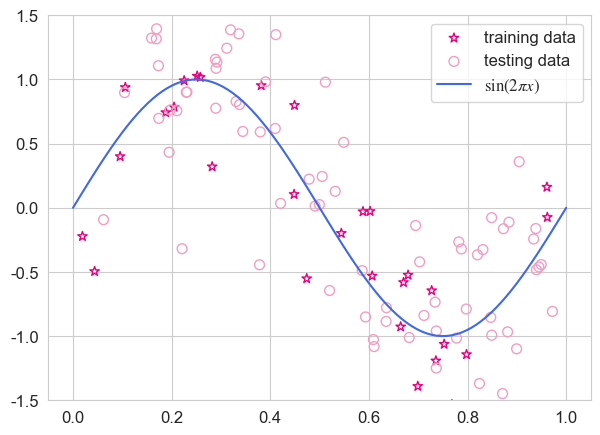

In [7]:
# 生成 sin 数据
# 由sin()函数生成数据
Data.seed_random(2024)    
# (1) 数据集构建
# 随机采集1000个样本，并进行可视化。
train_num = 30            # 训练样本数目
test_num = 80                # 测试样本数目
noise =   0.5 #  0.0 #       # 数据中加入方差为noise的Gaussian白噪声
# 生成数据
sin = Data.sin_data()
sin.gen_data(train_num=train_num,test_num=test_num,noise=noise)
# 训练数据集
train_dataset = (sin.train_data[0],sin.train_data[1])
# 测试数据集
test_dataset = (sin.test_data[0],sin.test_data[1])

# 绘制数据图像
fig_path = os.path.normpath('image/regression/sin_rbf/sin{}/fig/noise{}'.format(train_num,noise))
sin.draw_data(fig_path,fig_name=f'sin_train{train_num}_test{test_num}_n{noise}.pdf',
              train_data=train_dataset,test_data=test_dataset)

<font size=4 color=blue> **例 1** </font>   <font size=4 face="宋体"> 使用基于随机选取中心的 RBF网络（random_RBFNN）拟合sin函数</font>

(30, 1) (10, 1)
Train Error: 0.11750995699763452
(80, 1) (10, 1)
Test Error: 0.38566907341093254
0.42678603138864907


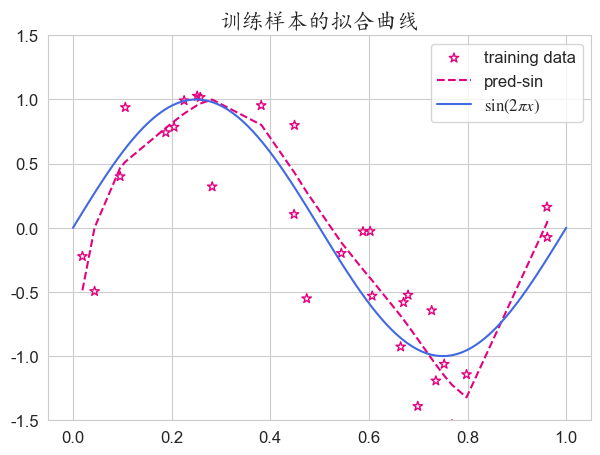

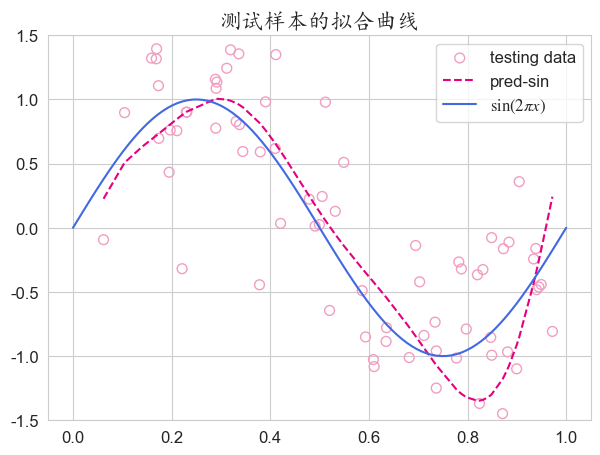

In [8]:
# 使用RBFNN拟合sin(x)
input_size = 1            # 输入层节点数目 N
hidden_size = 10           # 隐层神经元数目 M < P
output_size = 1           # 输出层神经元数目  L
                    
# 构建RBFNN 网络模型    
model = random_RBFNet(input_size,hidden_size,output_size)

# 实例化Runner类
runner = Runner(model,metric=mse)

# 训练网络
sigma =  None  #  0.1  #   1   #rbf函数扩展常数 （默认为1）
runner.train(train_dataset,test_dataset,sigma=sigma)

print(model.param['sigma'])

# (3.2) 绘制训练样本拟合曲线
#X_underlying = np.linspace(sin.interval[0],sin.interval[1],100) 
#y_underlying_pred = rbf.predict(X_underlying.reshape([-1,1]))
X_train,_ = train_dataset
y_train_pred = runner.train_pred
sin.draw_data(fig_path,fig_name='sin_rbf_train.pdf',
              train_data=train_dataset,
              train_data_pred=(X_train,y_train_pred),
              label='pred-sin',
              title = '训练样本的拟合曲线')

# (3.2) 绘制测试样本拟合曲线
#X_underlying = np.linspace(sin.interval[0],sin.interval[1],100) 
#y_underlying_pred = rbf.predict(X_underlying.reshape([-1,1]))
X_test,_ = test_dataset
y_test_pred = runner.test_pred
sin.draw_data(fig_path,fig_name='sin_rbf_test.pdf',
              test_data=test_dataset,
              test_data_pred=(X_test,y_test_pred),
              label='pred-sin',
              title = '测试样本的拟合曲线')


<font size=4 color=blue> **例 2** </font>   <font size=4 face="宋体"> 使用基于随机选取中心的正则化RBF网络（random_RBFNN）拟合sin函数</font>

(30, 1) (10, 1)
Train Error: 0.14412587632416293
(80, 1) (10, 1)
Test Error: 0.3458852398376886
0.4311735181306433


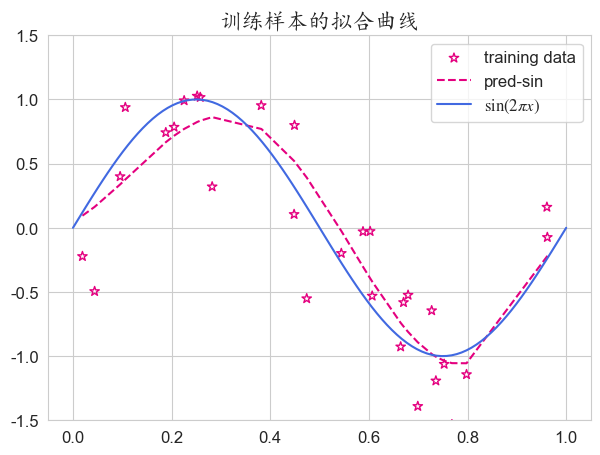

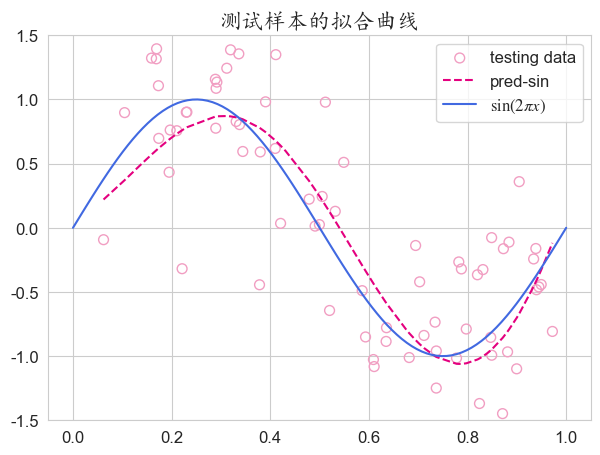

In [9]:
# 使用BFNN拟合sin(x)
input_size = 1            # 输入层节点数目 N
hidden_size = 10          # 隐层神经元数目 M
output_size = 1           # 输出层神经元数目  L
Lambda = 0.0001            # 正则化系数
                    
# 构建RBFNN 网络模型    
model = random_RBFNet(input_size,hidden_size,output_size,Lambda=Lambda)

# 实例化Runner类
runner = Runner(model,metric=mse)

# 训练网络
sigma = None  #   0.5  #    1   # rbf函数扩展常数 （默认为1）
runner.train(train_dataset,test_dataset,sigma=sigma)
print(model.param['sigma'])

# (3.2) 绘制训练样本拟合曲线
#X_underlying = np.linspace(sin.interval[0],sin.interval[1],100) 
#y_underlying_pred = rbf.predict(X_underlying.reshape([-1,1]))
X_train,_ = train_dataset
y_train_pred = runner.train_pred
sin.draw_data(fig_path,fig_name=f'sin_rrbf_train_{Lambda}.pdf',
              train_data=train_dataset,
              train_data_pred=(X_train,y_train_pred),
              label='pred-sin',
              title = '训练样本的拟合曲线')

# (3.2) 绘制测试样本拟合曲线
#X_underlying = np.linspace(sin.interval[0],sin.interval[1],100) 
#y_underlying_pred = rbf.predict(X_underlying.reshape([-1,1]))
X_test,_ = test_dataset
y_test_pred = runner.test_pred
sin.draw_data(fig_path,fig_name=f'sin_rrbf_test_{Lambda}.pdf',
              test_data=test_dataset,
              test_data_pred=(X_test,y_test_pred),
              label='pred-sin',
              title = '测试样本的拟合曲线')


<font size=4 color=blue> **例 3** </font>   <font size=4 face="宋体"> 使用基于k-means选取中心的 RBF网络（random_RBFNN）拟合sin函数</font>

D:\ProgramData\anaconda3\envs\env_pytorch\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Train Error: 0.09863056917658224
Test Error: 3.543505490341468
0.6575286277147493


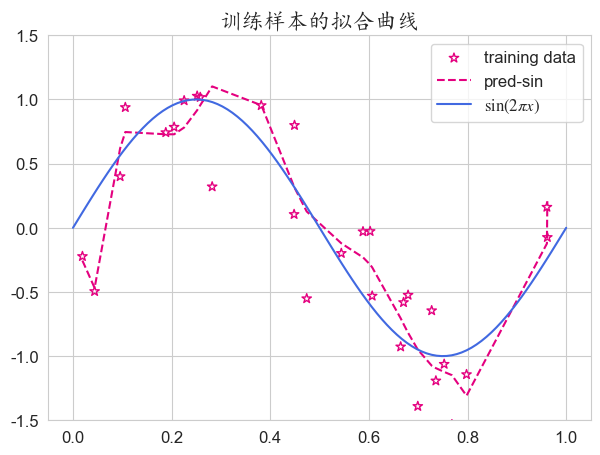

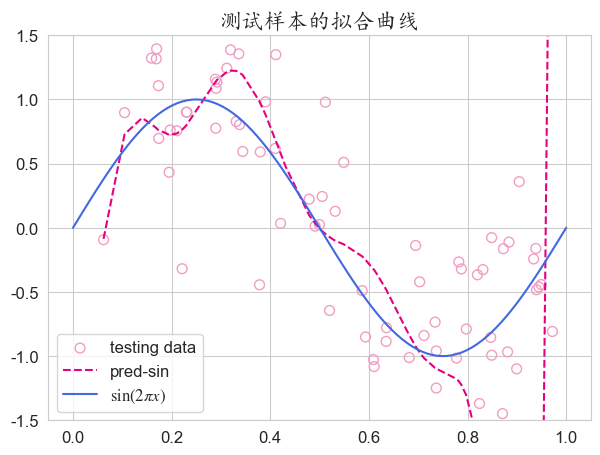

In [11]:
# 使用BFNN拟合sin(x)
input_size = 1            # 输入层节点数目 N
hidden_size = 10          # 隐层神经元数目 M
output_size = 1           # 输出层神经元数目  L
Lambda =  0.0  #   0.00001  #  # 正则化系数
#cluster = kMeans          # 聚类算法 kMeans（自己编写）   
cluster = KMeans          # 聚类算法  KMeans（from sklearn.cluster import KMeans)   

# 构建RBFNN 网络模型    
model = kmeans_RBFnet(input_size,hidden_size,output_size,cluster=cluster,Lambda=Lambda)

# 实例化Runner类
runner = Runner(model,metric=mse)

# 训练网络
sigma = None  #   0.5  #    1   # rbf函数扩展常数 （默认为1）
runner.train(train_dataset,test_dataset,sigma=sigma)
print(model.param['sigma'])

# (3.2) 绘制训练样本拟合曲线
#X_underlying = np.linspace(sin.interval[0],sin.interval[1],100) 
#y_underlying_pred = rbf.predict(X_underlying.reshape([-1,1]))
X_train,_ = train_dataset
y_train_pred = runner.train_pred
sin.draw_data(fig_path,fig_name=f'sin_kmeans_rbf_train_{Lambda}.pdf',
              train_data=train_dataset,
              train_data_pred=(X_train,y_train_pred),
              label='pred-sin',
              title = '训练样本的拟合曲线')

# (3.2) 绘制测试样本拟合曲线
#X_underlying = np.linspace(sin.interval[0],sin.interval[1],100) 
#y_underlying_pred = rbf.predict(X_underlying.reshape([-1,1]))
X_test,_ = test_dataset
y_test_pred = runner.test_pred
sin.draw_data(fig_path,fig_name=f'sin_kmeans_rbf_test_{Lambda}.pdf',
              test_data=test_dataset,
              test_data_pred=(X_test,y_test_pred),
              label='pred-sin',
              title = '测试样本的拟合曲线')
